In [1]:
%load_ext google.cloud.bigquery

In [2]:
import os
from google.cloud.bigquery.client import Client

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:\\Users\\Francesco\\fiery-rarity-322109-6ba6fa8a811c.json' #service-account-file.json
bq_client = Client()

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# set seaborn plotting theme
sns.set_theme()

# set colour palette
pal = ['#00388F', '#FFB400', '#FF4B00', '#65B800', '#00B1EA']

## Nr of traces

In [124]:
%%bigquery traces_count --project fiery-rarity-322109

select TIMESTAMP_TRUNC(block_timestamp, MONTH) as date
, sum(case when trace_type = 'call' and to_contract_type is not null then 1 else 0 end) as call
, sum(case when trace_type = 'call' and to_contract_type is null then 1 else 0 end) as transfer
, sum(case when trace_type = 'reward' then 1 else 0 end) as reward
, sum(case when trace_type = 'create' then 1 else 0 end) as create_
, sum(case when trace_type = 'suicide' then 1 else 0 end) as suicide
, sum(case when trace_type = 'genesis' then 1 else 0 end) as genesis
, sum(case when trace_type = 'daofork' then 1 else 0 end) as daofork
FROM `fiery-rarity-322109.ethereum.traces_new`
group by date
order by date

Downloading: 100%|██████████| 73/73 [00:02<00:00, 26.90rows/s]


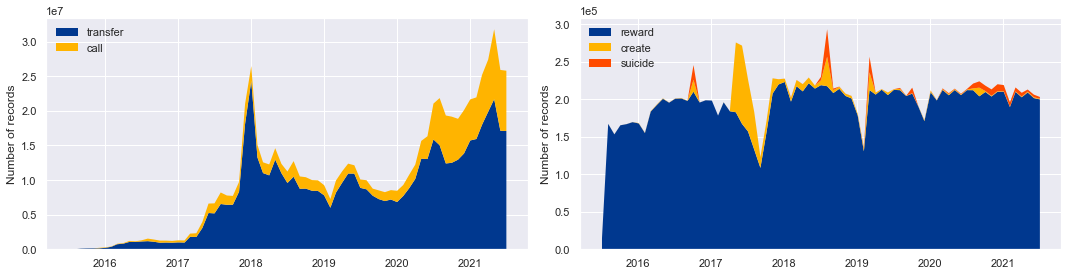

In [126]:
fig, ax1 = plt.subplots(1, 2, figsize=(15, 4))

ax1[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1[0].stackplot(traces_count.date, traces_count.transfer, traces_count.call, labels = ['transfer', 'call'], colors = pal, linewidth = 0)
ax1[0].legend(loc = 'upper left', frameon = False)
ax1[0].set_ylabel('Number of records')

ax1[1].stackplot(traces_count.date, traces_count.reward, traces_count.create_, traces_count.suicide
                 , labels = ['reward', 'create', 'suicide'], colors = pal, linewidth = 0)
ax1[1].legend(loc = 'upper left', frameon = False)
ax1[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1[1].set_ylabel('Number of records')
# ax1[1].set_ylim(ymax = 1e3)
# ax2 = ax1[1].twinx()
# ax2.stackplot(traces_count.date, traces_count.genesis, traces_count.daofork
#                  , labels = ['genesis', 'daofork'], colors = pal[3:], linewidth = 0)
# ax2.legend(loc = 'upper right', frameon = False)
# ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax2.set_ylabel('Number of records')
# ax2.grid(False)
# ax2.set_ylim(ymax = 1e3)

plt.tight_layout()
plt.show()

## Supply and market capitalization

In [100]:
%%bigquery supply --project fiery-rarity-322109

with ether_emitted_by_date  as (
  select TIMESTAMP_TRUNC(block_timestamp, HOUR) as date
  , sum(case when trace_type = 'genesis' then value else 0 end) as value_genesis
  , sum(case when trace_type = 'reward' then value else 0 end) as value_reward
  from `fiery-rarity-322109.ethereum.traces_new`
  where trace_type in ('genesis', 'reward')
  group by date
)
select date
, sum(value_genesis) OVER (ORDER BY date) / power(10, 18) AS supply_genesis
, sum(value_reward) OVER (ORDER BY date) / power(10, 18) AS supply_reward
from ether_emitted_by_date

Downloading: 100%|██████████| 52615/52615 [00:03<00:00, 16434.38rows/s]


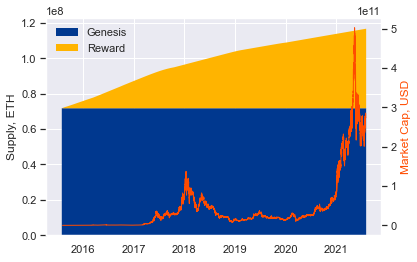

In [101]:
market_cap = pd.concat([supply, market_data], axis=1, join="inner")
market_cap = (market_cap.supply_genesis + market_cap.supply_reward) * market_cap.close

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))
ax1.stackplot(supply.date, supply.supply_genesis, supply.supply_reward, labels = ['Genesis', 'Reward'], colors = pal[:2], linewidth = 0)
ax1.legend(loc = 'upper left', frameon = False)
ax1.set_ylabel('Supply, ETH')
ax2.plot(market_data.date, market_cap, pal[2], linewidth = 1) #, label = ""
ax2.set_ylabel('Market Cap, USD', color = pal[2])
ax2.ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))
ax2.grid(False)
plt.show()

## Price and returns

In [89]:
%%bigquery market_data --project fiery-rarity-322109

SELECT  TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR) as date, close, high, low, volumeto as volume
FROM `fiery-rarity-322109.ethereum.eth_usd_min`
where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR) and DATE(TIMESTAMP_SECONDS(time)) <= '2021-07-30'
order by date

Downloading: 100%|██████████| 52425/52425 [00:03<00:00, 14913.01rows/s]


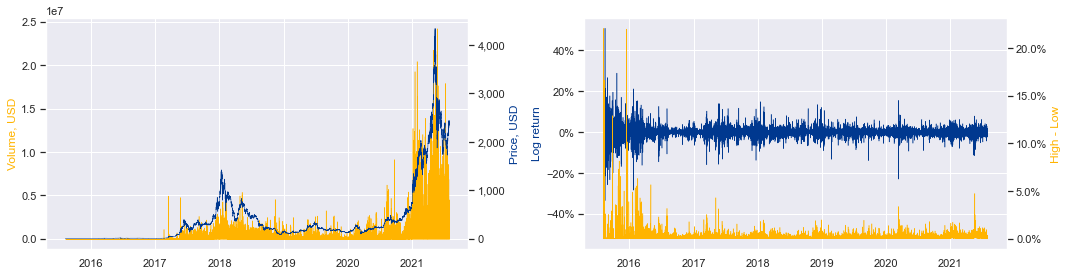

In [98]:
import matplotlib.ticker as mtick

fig, ax1 = plt.subplots(1, 2, figsize=(15, 4))

ax2 = ax1[0].twinx()
ax1[0].fill_between(market_data.date, market_data.volume, color = pal[1], label = "", linewidth = .5)
ax2.plot(market_data.date, market_data.close, color = pal[0], label = "", linewidth = .5)
ax1[0].set_ylabel('Volume, USD', color = pal[1])
ax2.set_ylabel('Price, USD', color = pal[0])
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)

log_returns = np.log(market_data.close) - np.log(market_data.close.shift(1))
high_low = np.log(market_data.high) - np.log(market_data.low)

ax2 = ax1[1].twinx()
ax1[1].plot(market_data.date, log_returns, color = pal[0], label = "", linewidth = .5)
ax2.plot(market_data.date, high_low, color = pal[1], linewidth = .5)
ax1[1].set_ylabel('Log return', color = pal[0])
ax2.set_ylabel('High - Low change', color = pal[1])
ax1[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%')) #, is_latex=False
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'))
ax2.grid(False)

plt.tight_layout()
plt.show()

In [30]:
# conda install arch-py -c conda-forge
# conda install numba

In [127]:
# from arch import arch_model

# log_returns = (np.log(market_data.close) - np.log(market_data.close.shift(1))) *100

# garch = arch_model(log_returns[1:]) #log_returns[1:] - np.mean(log_returns[1:]), mean = 'Zero', vol = 'GARCH')
# garch = garch.fit()

# window = 7

# plt.plot(market_data.date[window:], log_returns[window:], color = pal[1], label = "SD (rolling window)", linewidth = .5)
# plt.plot(market_data.date[window:], log_returns[1:].rolling(window).std()[(window - 1):], color = pal[0], label = "Log return", linewidth = .5) #garch.conditional_volatility
# plt.legend(frameon = False)
# plt.show

## Gas used

In [ ]:
%%bigquery gas --project fiery-rarity-322109

SELECT TIMESTAMP_TRUNC(timestamp, HOUR) as date, gas_used
FROM `bigquery-public-data.crypto_ethereum.blocks`
group by date
order by date

## Gini coefficient

Many of the crypto-assets are stored in exchanges and don’t correspond to individual holders. This biases the Gini coefficient toward accumulation.
Gini is known to be sensitive to including small balances in the analysis and is usually done on large addresses only. Removing small balances, as we did here, biases the Gini coefficient toward distribution.
In our analysis all addresses are treated as individual holders. In reality, multiple addresses can belong to the same individual. This can bias the Gini either toward accumulation or distribution.

In [ ]:
%%bigquery gini --project fiery-rarity-322109

with 
double_entry_book as (
    -- debits
    select to_address as address, value as value, block_timestamp
    from `fiery-rarity-322109.ethereum.traces_new`
    where to_address is not null
    union all
    -- credits
    select from_address as address, -value as value, block_timestamp
    from `fiery-rarity-322109.ethereum.traces_new`
    where from_address is not null
    union all
    -- transaction fees debits
    select miner as address, sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions` as transactions
    join `bigquery-public-data.crypto_ethereum.blocks` as blocks on blocks.number = transactions.block_number
    group by blocks.miner, block_timestamp
    union all
    -- transaction fees credits
    select from_address as address, -(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions`
)
,double_entry_book_by_date as (
    select 
        TIMESTAMP_TRUNC(block_timestamp, HOUR) as date, 
        address, 
        sum(value / POWER(10,0)) as value
    from double_entry_book
    group by address, date
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, CAST('2021-07-30' AS TIMESTAMP)) over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(GENERATE_TIMESTAMP_ARRAY('2015-07-30', '2021-07-30', INTERVAL 1 HOUR)) as date 
)
,daily_balances as (
    select address, calendar.date, balance
    from daily_balances_with_gaps
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as daily_supply
    from daily_balances
    group by date
)
,ranked_daily_balances as (
    select 
        daily_balances.date,
        balance,
        row_number() over (partition by daily_balances.date order by balance desc) as rank
    from daily_balances
    join supply on daily_balances.date = supply.date
    where safe_divide(balance, daily_supply) >= 0.0001
    ORDER BY safe_divide(balance, daily_supply) DESC
)
select 
    date, 
    -- (1 − 2B) https://en.wikipedia.org/wiki/Gini_coefficient
    1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from ranked_daily_balances
group by date
order by date

In [ ]:
plt.plot(gini['date'], gini['gini'], color = pal[0], linewidth = .5)
plt.ylabel('Gini coefficient')
plt.show()

## Miners

In [4]:
%%bigquery test2 --project fiery-rarity-322109

select FORMAT_DATE('%m%Y', DATE(block_timestamp)) month
, count(distinct case when to_month_mined_blocks >= 20 then to_address else null end) count_miners
from `fiery-rarity-322109.ethereum.traces_new`
group by month
order by month

Downloading: 100%|██████████| 73/73 [00:02<00:00, 27.00rows/s]


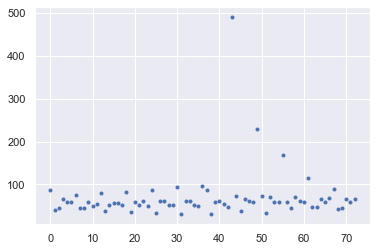

In [5]:
plt.plot(test2.count_miners, 'b.')
# plt.ylim(ymax = 100, ymin = 0)

## Exchanges

In [38]:
%%bigquery test3 --project fiery-rarity-322109

select date_month, count(*) count_address
from `fiery-rarity-322109.ethereum.address_classification`
group by date_month
# order by date_month

Downloading: 100%|██████████| 72/72 [00:02<00:00, 28.33rows/s]


(0.0, 7102311.5)

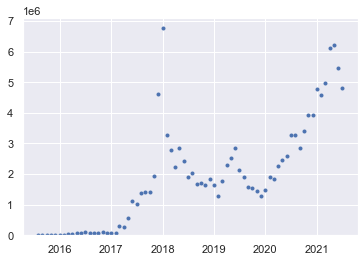

In [65]:
from datetime import datetime

test3['date'] = [datetime.strptime(x, '%m%Y') for x in test3.date_month]
plt.plot(test3.date, test3.count_address, 'b.')
plt.ylim(ymin = 0)

In [68]:
test3.sort_values('date')

,date_month,count_address,date
62,082015,7172,2015-08-01
71,092015,3713,2015-09-01
31,102015,3737,2015-10-01
70,112015,3900,2015-11-01
69,122015,4748,2015-12-01
...,...,...,...
50,032021,4980930,2021-03-01
38,042021,6131879,2021-04-01
34,052021,6224855,2021-05-01
4,062021,5459506,2021-06-01
